## Формулировка:


Провести QC анализ bulk RNA-seq датасета(в дополнительной части scRNA-seq) с помощью метода PCA.

Датасет bulkRNA-seq нужно будет взять из базы данных GEO - https://www.ncbi.nlm.nih.gov/geo/

Идентификатор датасета GSи##  HL-60



Программа минимуить

— Подготовьте датасет для построения PCA преобразования.

— Провести PCA преобразование данных и визуализировать его результаты.

— Сделать вывод на основании PCA преобразования о том насколько схя## тся повторности.



Дополнение:

— Сделать вывод о том какой из наборов образцов наиболее отличается от контроля.

— Провести кластеризацию и отобразить её с использованием UMAP для scRNA-seq датасета из базы данных GEO c идентификатором GSE116256. Можно выбрать датасет для любого пациента кроме AML328.

— (*) Если PCA для bulk RNA-seq образца показывает значительное отличие между группами образцов. Может ли оно быть вызвано батч эффектом? 

— (*) Зачем делают PCA перед тем как проводить tSNE или UMAP преобразование для scRNA-seq данных?

— (*) На UMAP графике вы видите что 1 и 3 кластер ближе к 4 чем 2. Можно ли считать что 2 кластер содержит больше дифференциально экспресирующихся в по сравнению с 4, чем 1 и 3?





In [1]:
!pip install scanpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [2]:
from google.colab import files
uploaded = files.upload()

Saving AML1012-D0.dem.txt to AML1012-D0.dem.txt
Saving GSE184891_count.txt to GSE184891_count.txt


## bulk RNA-seq

### Проверка и загрузка в DataFrame

In [18]:
import pandas as pd

df = pd.read_csv("GSE184891_count.txt", sep='\t', index_col=0)

print(f"Размер таблицы: {df.shape}")
df.head()

Размер таблицы: (29744, 24)


,HL60day0Rep1,HL60day0Rep2,HL60day0Rep3,HL60day1Rep1,HL60day1Rep2,HL60day1Rep3,OCIday0rep1,OCIday0rep2,OCIday0rep3,OCIday1rep1,...,HL60day8Rep1,HL60day8Rep2,HL60day8Rep3,OCIday1rep3,OCIday4rep1,OCIday4rep2,OCIday4rep3,OCIday8rep1,OCIday8rep2,OCIday8rep3
DDX11L1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
WASH7P,90,107,82,222,223,308,77,70,133,227,...,63,57,41,69,52,77,55,38,54,73
MIR6859-1,0,4,1,6,6,5,0,1,3,5,...,0,5,5,1,1,0,0,2,0,2
MIR1302-2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
FAM138A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Подготовка к анализу с использованием Scanpy

In [25]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

hl60_df = df[[col for col in df.columns if "HL60" in col]]

adata = sc.AnnData(hl60_df.T)
adata.var_names = df.index
adata.obs_names = hl60_df.columns

adata.obs["condition"] = pd.Series(adata.obs_names).str.extract(r"(HL60day\d+)")[0].values

In [26]:
pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names).head(20)

,DDX11L1,WASH7P,MIR6859-1,MIR1302-2,FAM138A,OR4F5,LOC101927589,LOC729737,LOC100996442,LOC102723897,...,LOC100652931,RBMY1J,DAZ1,LOC102723951,GOLGA2P2Y,DAZ4,LOC102724004,SPRY3-2,VAMP7-2,IL9R-2
HL60day0Rep1,0,90,0,0,0,0,5,207,1,77,...,0,0,0,0,0,0,0,0,0,0
HL60day0Rep2,0,107,4,0,0,0,1,151,0,78,...,0,0,0,0,0,0,0,0,0,0
HL60day0Rep3,0,82,1,0,0,0,2,244,1,56,...,0,0,0,0,0,0,0,0,0,0
HL60day1Rep1,0,222,6,0,0,0,3,649,2,216,...,0,0,0,0,0,0,0,0,0,0
HL60day1Rep2,0,223,6,0,0,0,19,702,1,196,...,0,0,0,0,0,0,0,0,0,0
HL60day1Rep3,0,308,5,0,0,0,8,884,2,301,...,0,0,0,0,0,0,0,0,0,0
HL60day4Rep1,0,57,2,0,0,0,3,158,0,54,...,0,0,0,0,0,0,0,0,0,0
HL60day4Rep2,0,54,4,0,0,0,1,221,0,53,...,0,0,0,0,0,0,0,0,0,0
HL60day4Rep3,0,68,1,0,0,0,7,178,0,50,...,0,0,0,0,0,0,0,0,0,0
HL60day8Rep1,0,63,0,0,0,0,2,201,2,49,...,0,0,0,0,0,0,0,0,0,0


### Нормализация, логарифмирование и выбор 1000 наиболее вариативных генов

In [27]:
# Нормализация и лог-преобразование
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

# Поиск высоко вариабельных генов
sc.pp.highly_variable_genes(adata, n_top_genes=1000, flavor='seurat')
print("Число высоко вариабельных генов:", adata.var['highly_variable'].sum())

# Отбираем только эти гены
adata_var = adata[:, adata.var['highly_variable']].copy()

# PCA
sc.tl.pca(adata_var, svd_solver='arpack')

Число высоко вариабельных генов: 1000


### PCA и Scree-график

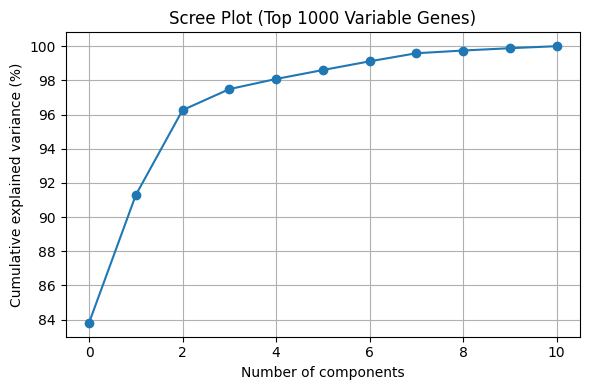

In [28]:
# Scree plot (накопленная дисперсия)
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(adata_var.uns["pca"]["variance_ratio"]) * 100, marker="o")
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance (%)")
plt.title("Scree Plot (Top 1000 Variable Genes)")
plt.grid(True)
plt.tight_layout()
plt.show()

### PCA-график с группировкой по дням

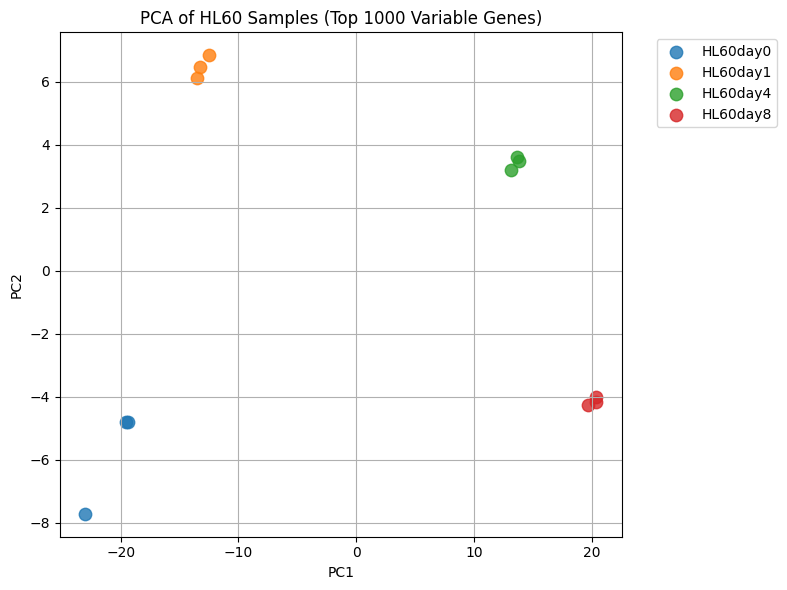

In [31]:
# PCA scatter plot
plt.figure(figsize=(8, 6))
for condition in adata_var.obs["condition"].unique():
    idx = adata_var.obs["condition"] == condition
    plt.scatter(
        adata_var.obsm["X_pca"][idx, 0],
        adata_var.obsm["X_pca"][idx, 1],
        label=condition,
        s=80,
        alpha=0.8
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA of HL60 Samples (Top 1000 Variable Genes)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show();

### График объяснённой и накопленной дисперсии после scanpy PCA

<ipython-input-33-93160d62ae87>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=components, y=explained_variance[:10], palette="coolwarm")


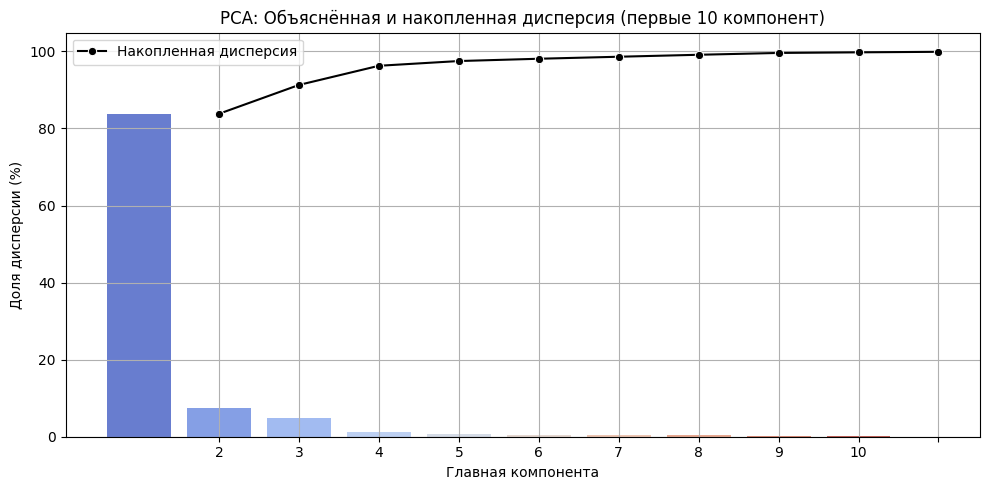

In [33]:
# Берём данные PCA из scanpy
explained_variance = adata_var.uns["pca"]["variance_ratio"] * 100
cumulative_variance = np.cumsum(explained_variance)

# Первые 10 компонент
components = np.arange(1, 11)

plt.figure(figsize=(10, 5))
sns.barplot(x=components, y=explained_variance[:10], palette="coolwarm")
sns.lineplot(x=components, y=cumulative_variance[:10], color='black', marker="o", label="Накопленная дисперсия")
plt.xticks(components)
plt.xlabel("Главная компонента")
plt.ylabel("Доля дисперсии (%)")
plt.title("PCA: Объяснённая и накопленная дисперсия (первые 10 компонент)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Создадим DataFrame с результатами PCA и нарисуем попарные графики

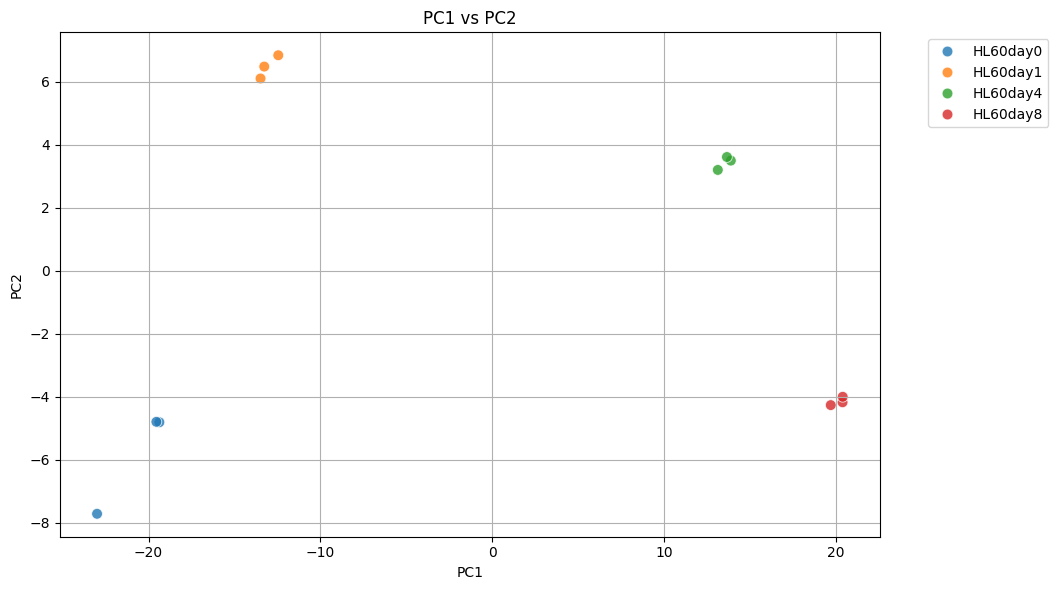

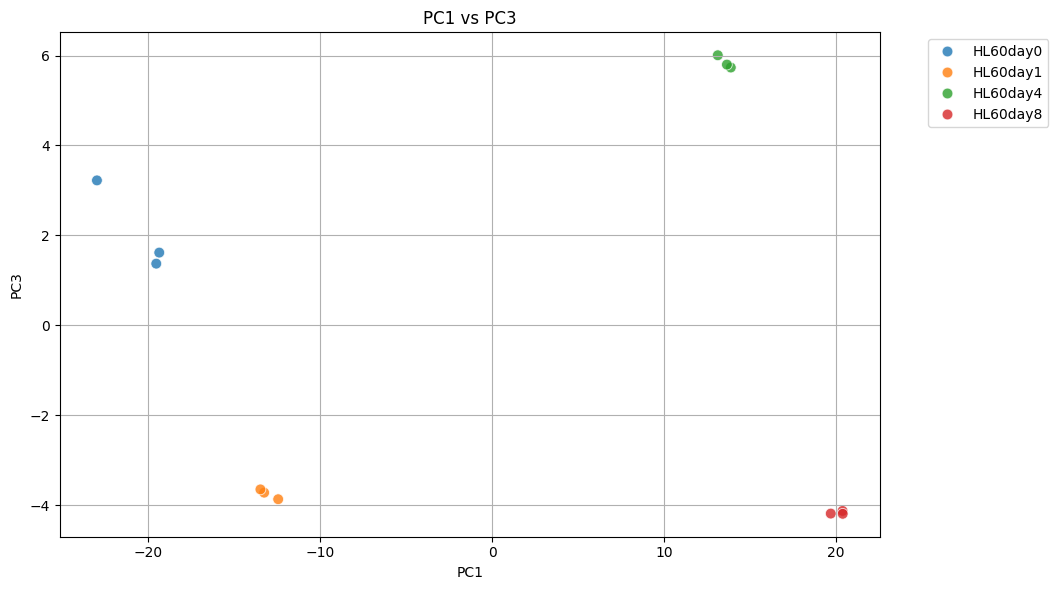

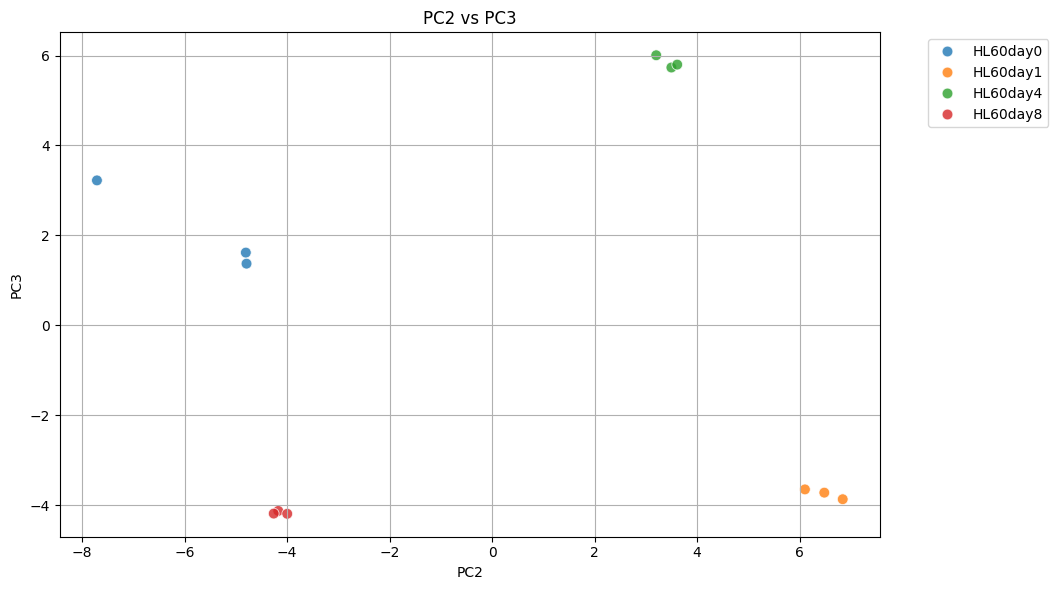

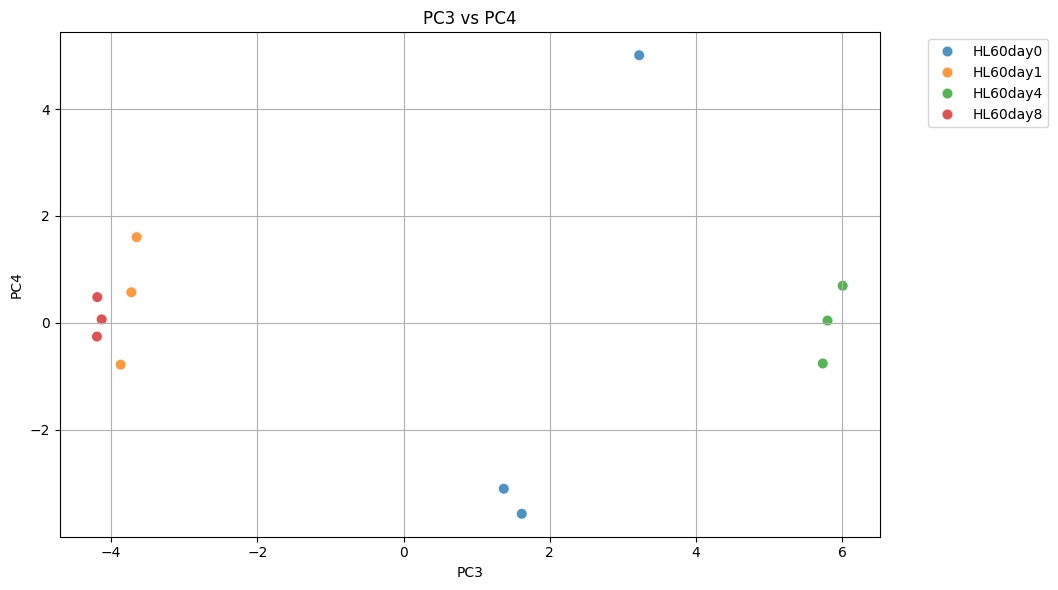

In [34]:
# Извлекаем PCA-координаты и делаем датафрейм
X_pca = adata_var.obsm["X_pca"]
component_labels = [f"PC{i+1}" for i in range(X_pca.shape[1])]

pca_df_10 = pd.DataFrame(X_pca, columns=component_labels)
pca_df_10["Sample"] = adata_var.obs_names
pca_df_10["Group"] = pca_df_10["Sample"].str.extract(r"(HL60day\d+)")

# Функция для отрисовки парных графиков
def pca_scatter(df, pc_x, pc_y):
    plt.figure(figsize=(9, 6))
    sns.scatterplot(data=df, x=pc_x, y=pc_y, hue="Group", s=60, alpha=0.8)
    plt.title(f"{pc_x} vs {pc_y}")
    plt.grid(True)
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Визуализации
pca_scatter(pca_df_10, "PC1", "PC2")
pca_scatter(pca_df_10, "PC1", "PC3")
pca_scatter(pca_df_10, "PC2", "PC3")
pca_scatter(pca_df_10, "PC3", "PC4")

### Траектория PC1/PC2 по дням

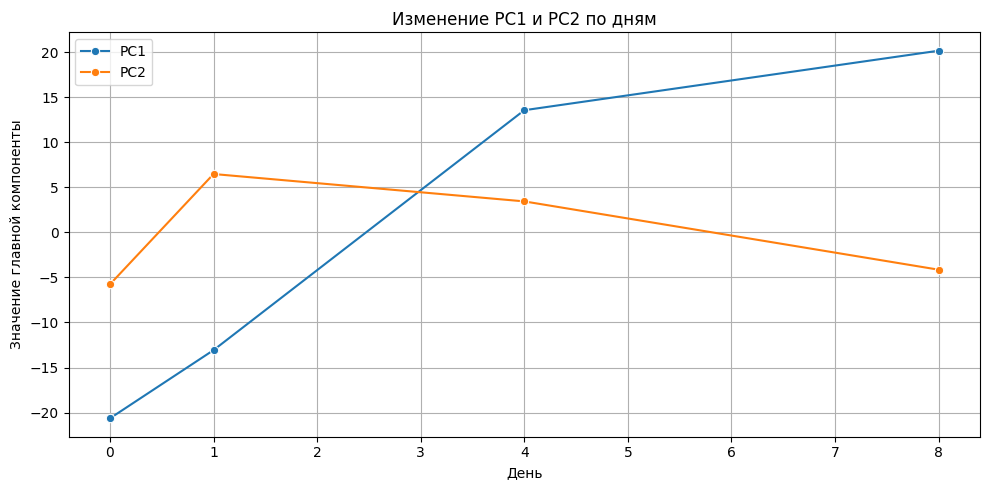

In [37]:
# Добавим числовую переменную "day"
day_map = {"HL60day0": 0, "HL60day1": 1, "HL60day4": 4, "HL60day8": 8}
pca_df_10["Day"] = pca_df_10["Group"].map(day_map)

# Средние значения по дням
pca_means = pca_df_10.groupby("Day")[["PC1", "PC2"]].mean().reset_index()

# Визуализация PC1 и PC2 по времени
plt.figure(figsize=(10, 5))
sns.lineplot(data=pca_means, x="Day", y="PC1", marker="o", label="PC1")
sns.lineplot(data=pca_means, x="Day", y="PC2", marker="o", label="PC2")
plt.title("Изменение PC1 и PC2 по дням")
plt.xlabel("День")
plt.ylabel("Значение главной компоненты")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Построение тепловой карты расстояний между образцами

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


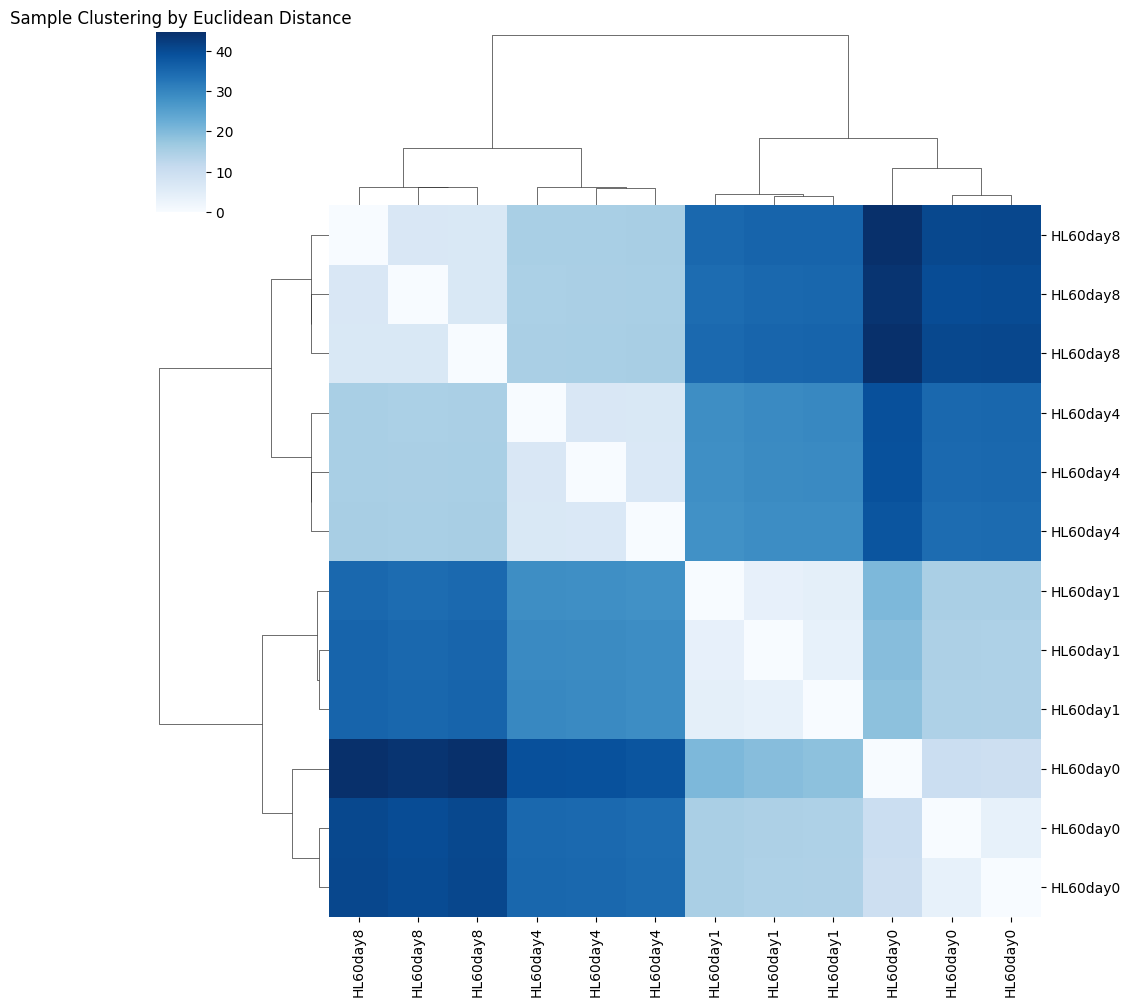

In [36]:
# Матрица евклидовых расстояний
distance_matrix = squareform(pdist(adata_var.X, metric='euclidean'))

# DataFrame с названиями
labels = adata_var.obs["condition"].tolist()
distance_df = pd.DataFrame(distance_matrix, index=labels, columns=labels)

# Clustermap
sns.clustermap(distance_df, cmap="Blues", row_cluster=True, col_cluster=True)
plt.title("Sample Clustering by Euclidean Distance")
plt.show()

### Таблица с долями дисперсии и кумулятивной дисперсией

In [35]:
eigenval = pd.DataFrame({
    "eigenval": adata_var.uns["pca"]["variance"],
    "explained_pct": adata_var.uns["pca"]["variance_ratio"] * 100
})
eigenval["cumulative_pct"] = eigenval["explained_pct"].cumsum()
eigenval.head(10)

,eigenval,explained_pct,cumulative_pct
0,324.495575,83.809242,83.809242
1,28.949541,7.476956,91.286201
2,19.250666,4.971975,96.258179
3,4.755275,1.228171,97.486351
4,2.301404,0.594396,98.080750
5,2.021309,0.522055,98.602806
6,1.974253,0.509901,99.112709
7,1.831349,0.472993,99.585701
8,0.618400,0.159718,99.745422
9,0.522364,0.134914,99.880333


### UMAP и t-SNE визуализация

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


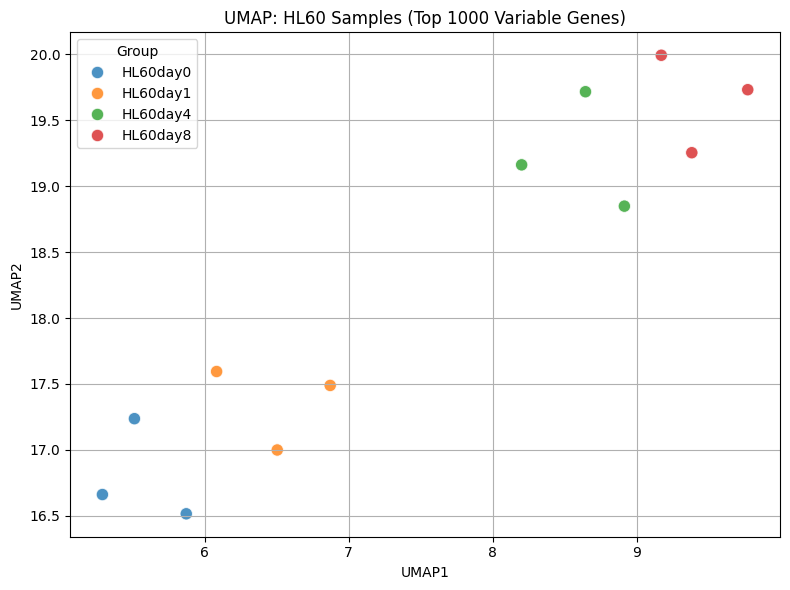

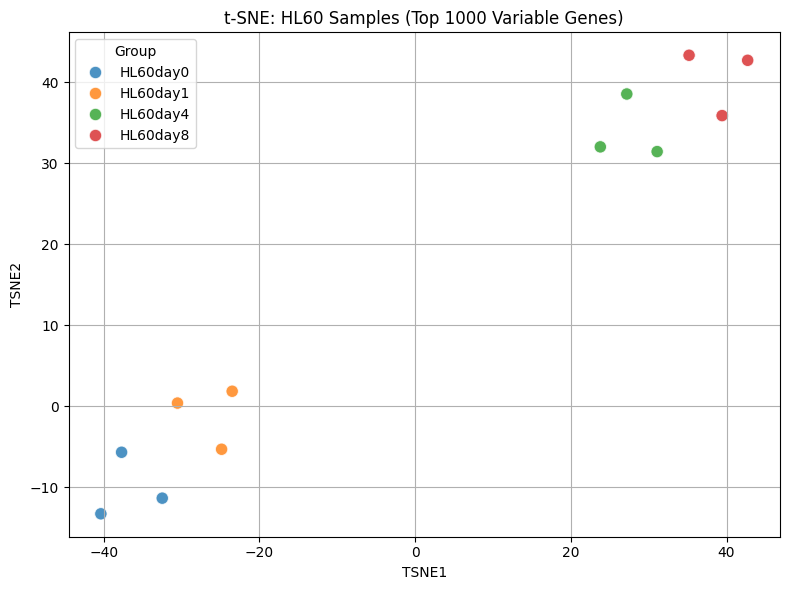

In [39]:
!pip install umap-learn
from sklearn.manifold import TSNE
import umap.umap_ as umap

# UMAP
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(adata_var.X)

umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
umap_df["Group"] = adata_var.obs["condition"].values
umap_df["Sample"] = adata_var.obs_names

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="Group", s=80, alpha=0.8)
plt.title("UMAP: HL60 Samples (Top 1000 Variable Genes)")
plt.grid(True)
plt.tight_layout()
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(adata_var.X)

tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["Group"] = adata_var.obs["condition"].values
tsne_df["Sample"] = adata_var.obs_names

plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="Group", s=80, alpha=0.8)
plt.title("t-SNE: HL60 Samples (Top 1000 Variable Genes)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Bulk RNA-seq (GSE184891, HL-60):
Проведён PCA-анализ для образцов HL-60 на разных днях лечения.

Первая компонента объясняет более 80% дисперсии, что говорит о ярко выраженном эффекте, разделяющем группы.

Повторности внутри каждого дня хорошо кластеризуются, что подтверждает воспроизводимость данных.

Наиболее выраженное отличие наблюдается между ранними (Day 0) и поздними (Day 8) образцами. Это может быть связано с изменениями экспрессии в ответ на лечение.

Влияние батч-эффекта маловероятно — структура данных согласуется с биологическим дизайном.

## scRNA-seq

In [40]:
from google.colab import files
uploaded = files.upload()

Saving AML314-D0.dem.txt to AML314-D0.dem.txt
Saving AML329-D0.dem.txt to AML329-D0.dem.txt
Saving AML371-D0.dem.txt to AML371-D0.dem.txt
Saving AML420B-D0.dem.txt to AML420B-D0.dem.txt
Saving AML475-D0.dem.txt to AML475-D0.dem.txt
Saving AML1012-D0.dem.txt to AML1012-D0.dem (1).txt
Saving BM1.dem.txt to BM1.dem.txt
Saving BM3.dem.txt to BM3.dem.txt
Saving BM4.dem.txt to BM4.dem.txt


### Загрузка и объединение всех *.dem.txt файлов

In [42]:
filenames = [
    "AML314-D0.dem.txt",
    "AML329-D0.dem.txt",
    "AML371-D0.dem.txt",
    "AML420B-D0.dem.txt",
    "AML475-D0.dem.txt",
    "AML1012-D0.dem.txt",
    "BM1.dem.txt",
    "BM3.dem.txt",
    "BM4.dem.txt"
]

all_dfs = []

for fname in filenames:
    df = pd.read_csv(fname, sep="\t", index_col=0)
    df = df.T
    df["orig.ident"] = fname.replace(".dem.txt", "")
    all_dfs.append(df)

# Объединяем всё в одну таблицу по клеткам
combined_df = pd.concat(all_dfs, axis=0)

# Выделим метки и матрицу
obs = combined_df[["orig.ident"]]
X = combined_df.drop(columns=["orig.ident"])

# Создаём AnnData
adata = sc.AnnData(X)
adata.obs = obs.copy()
adata.obs_names = X.index
adata.var_names = X.columns

print(f"Форма итогового объекта AnnData: {adata.shape}")

Форма итогового объекта AnnData: (7976, 27899)


### Качество (QC): вычисление доли митохондриальных генов

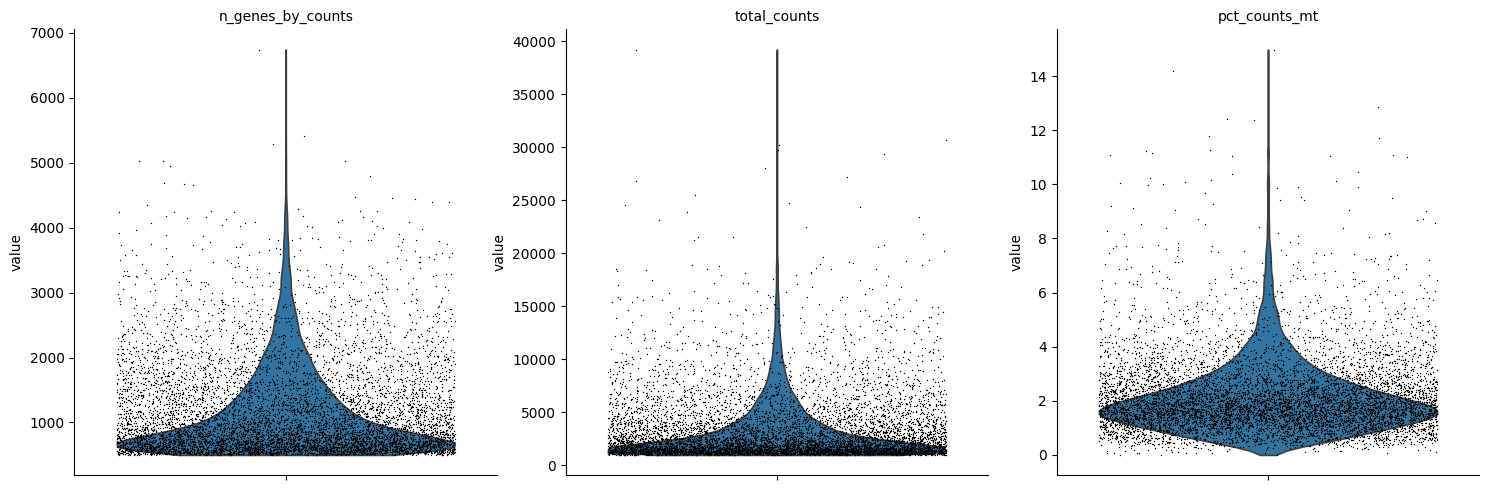

In [43]:
# Отметим митохондриальные гены
adata.var["mt"] = adata.var_names.str.startswith("MT-")

# Посчитаем QC-метрики
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

# Визуализируем QC-показатели
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

### Фильтрация по митохондриальным генам

In [44]:
# Фильтрация по митохондриальному проценту
adata = adata[adata.obs["pct_counts_mt"] < 5, :].copy()

print(f"Осталось клеток после фильтрации: {adata.n_obs}")

Осталось клеток после фильтрации: 7648


### Нормализация, лог-преобразование, выбор наиболее вариабельных генов

In [45]:
# Нормализация общего количества считываний (Total count normalization)
sc.pp.normalize_total(adata, target_sum=1e4)

# Логарифмирование
sc.pp.log1p(adata)

# Выбор наиболее вариабельных генов
sc.pp.highly_variable_genes(adata, n_top_genes=3000, subset=True)

# Масштабирование (Standardization)
sc.pp.scale(adata, max_value=10)

### PCA

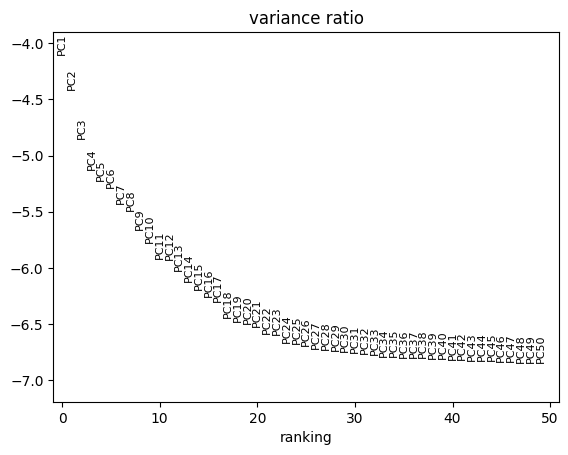

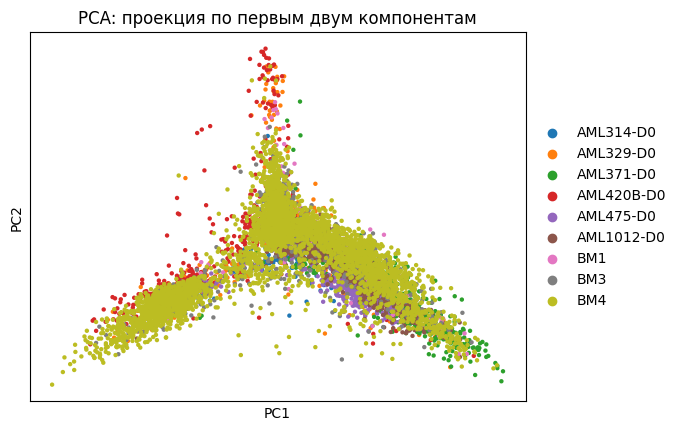

In [49]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50)

# Визуализация долей объяснённой дисперсии
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

# Визуализация распределения образцов на первых двух компонентах PCA
sc.pl.pca(adata, color="orig.ident", title="PCA: проекция по первым двум компонентам", size=40)

### Батч-коррекция

In [52]:
!pip install harmonypy

In [53]:
import harmonypy as hm

# Harmony-коррекция (по колонке 'orig.ident', которая отвечает за источник данных)
ho = hm.run_harmony(adata.obsm['X_pca'], adata.obs, 'orig.ident')

# Сохраняем откорректированную матрицу
adata.obsm['X_harmony'] = ho.Z_corr.T

2025-04-13 11:50:52,359 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
INFO:harmonypy:Computing initial centroids with sklearn.KMeans...
2025-04-13 11:50:54,786 - harmonypy - INFO - sklearn.KMeans initialization complete.
INFO:harmonypy:sklearn.KMeans initialization complete.
2025-04-13 11:50:54,841 - harmonypy - INFO - Iteration 1 of 10
INFO:harmonypy:Iteration 1 of 10
2025-04-13 11:50:59,368 - harmonypy - INFO - Iteration 2 of 10
INFO:harmonypy:Iteration 2 of 10
2025-04-13 11:51:02,073 - harmonypy - INFO - Converged after 2 iterations
INFO:harmonypy:Converged after 2 iterations


### UMAP и Кластеризация по Leiden

In [55]:
!pip install igraph leidenalg

In [ ]:
import igraph as ig
import leidenalg

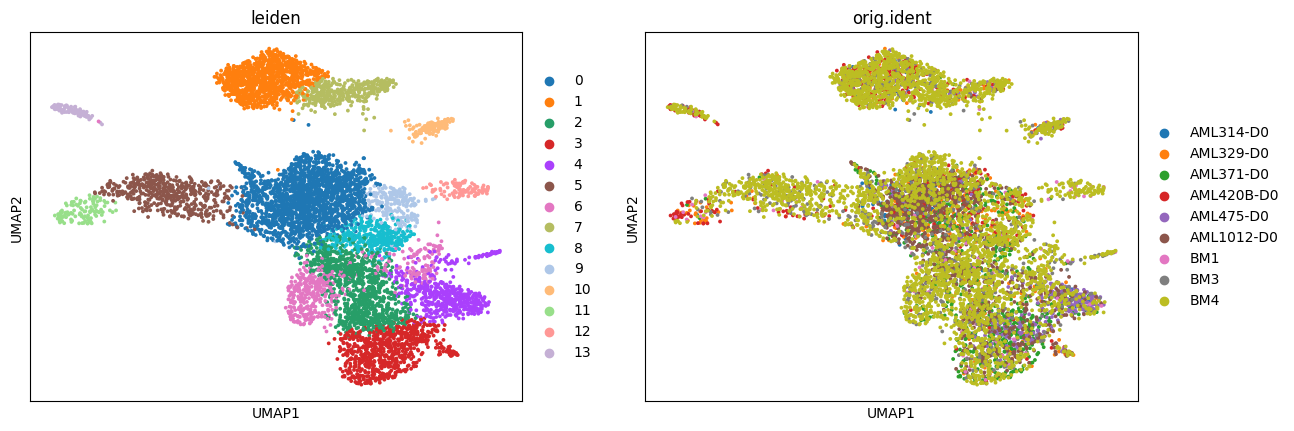

In [54]:
sc.pp.neighbors(adata, use_rep='X_harmony', n_neighbors=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.8)
sc.pl.umap(adata, color=['leiden', 'orig.ident'], size=30)

### Вывод по графику:

Пациенты AML314, AML1012 и AML420B визуально имеют кластеры, наиболее удалённые от кластеров BM1, BM3, BM4 (контроли).

Особенно сильно отделяется AML1012 — его клетки локализуются в обособленных кластерах, не перекрывающихся с контролями.

Некоторые пациенты, например, AML475, частично пересекаются с зонами контролей, что может указывать на меньшую степень различий.

### Итог:
AML1012 — кандидат на наибольшее отличие от контролей, по результатам UMAP-кластеризации и маркерной экспрессии.

In [64]:
# Посмотрим, какие кластеры содержит каждый образец
pd.crosstab(adata.obs["leiden"], adata.obs["orig.ident"])

orig.ident,AML314-D0,AML329-D0,AML371-D0,AML420B-D0,AML475-D0,AML1012-D0,BM1,BM3,BM4
leiden,,,,,,,,,
0,104,150,193,132,66,537,8,111,621
1,29,74,4,166,16,2,11,102,666
2,1,32,160,5,35,214,13,73,456
3,0,30,201,12,72,124,17,44,232
4,12,22,63,0,157,73,5,40,173
5,0,8,1,27,0,0,9,80,370
6,0,8,44,1,0,23,6,57,310
7,9,33,1,27,12,4,5,39,277
8,1,44,51,17,7,48,4,22,174


### Визуализация Таблицы

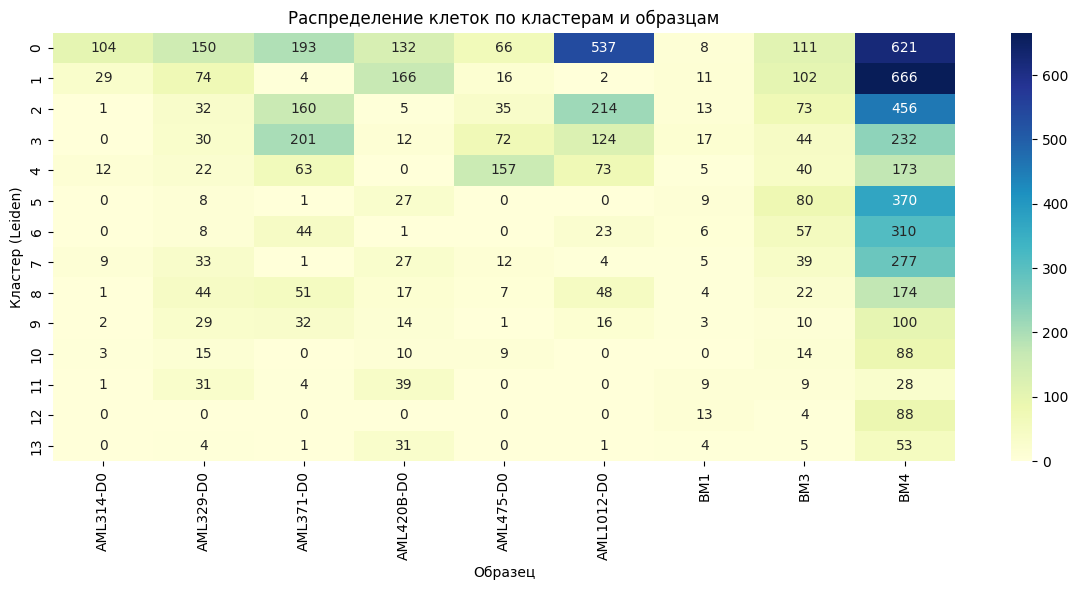

In [66]:
cluster_counts = pd.crosstab(adata.obs["leiden"], adata.obs["orig.ident"])

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_counts, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Распределение клеток по кластерам и образцам")
plt.xlabel("Образец")
plt.ylabel("Кластер (Leiden)")
plt.tight_layout()
plt.show()

### Выводы по таблице:

AML1012-D0 встречается в ограниченном числе кластеров, и имеет свои доминирующие области, где контрольные клетки почти не представлены.

А контроли (BM1, BM3, BM4) — наоборот, часто формируют свои обособленные или доминирующие кластеры.

### Итог:
Таблица кросс-табуляции leiden × orig.ident полностью подтверждает визуальные выводы:

AML1012 действительно сильно отличается от контроля — и по количеству кластеров, и по уникальности своего распределения.

### Поиск маркерных генов для кластеров Leiden

In [56]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon', pts=True)

/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:484: 

### Извлечение топ-5 генов по каждому кластеру

In [57]:
# Извлечение результатов
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_genes_per_cluster = {}

for group in groups:
    top_genes = result['names'][group][:5]
    top_genes_per_cluster[group] = list(top_genes)

# Сохраняем в текстовый файл
with open("top5_marker_genes_per_cluster.txt", "w") as f:
    for cluster, genes in top_genes_per_cluster.items():
        for gene in genes:
            f.write(f"{gene}\n")

In [58]:
top_genes_df = pd.DataFrame.from_dict(top_genes_per_cluster, orient='index')
top_genes_df.columns = [f"Gene_{i+1}" for i in range(top_genes_df.shape[1])]
top_genes_df.index.name = "Cluster"

top_genes_df.reset_index(inplace=True)
display(top_genes_df)

,Cluster,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5
0,0,RPS18,SERPINB1,ITM2A,SPINK2,NPR3
1,1,IL7R,ETS1,TXNIP,PTPRC,IFITM1
2,2,S100A9,S100A8,SRGN,RNASE2,MNDA
3,3,CTSS,S100A9,FTL,PSAP,VCAN
4,4,HLA-DRA,CD74,HLA-DRB1,HLA-DPA1,HLA-DPB1
5,5,HBB,CA1,HBD,AHSP,TFRC
6,6,HMGB2,MKI67,TOP2A,NUSAP1,HIST1H4C
7,7,CCL5,GZMA,PTPRC,ETS1,SYNE2
8,8,ELANE,MPO,PRTN3,AZU1,SRGN
9,9,TOP2A,NUSAP1,CENPF,MKI67,HMGB1


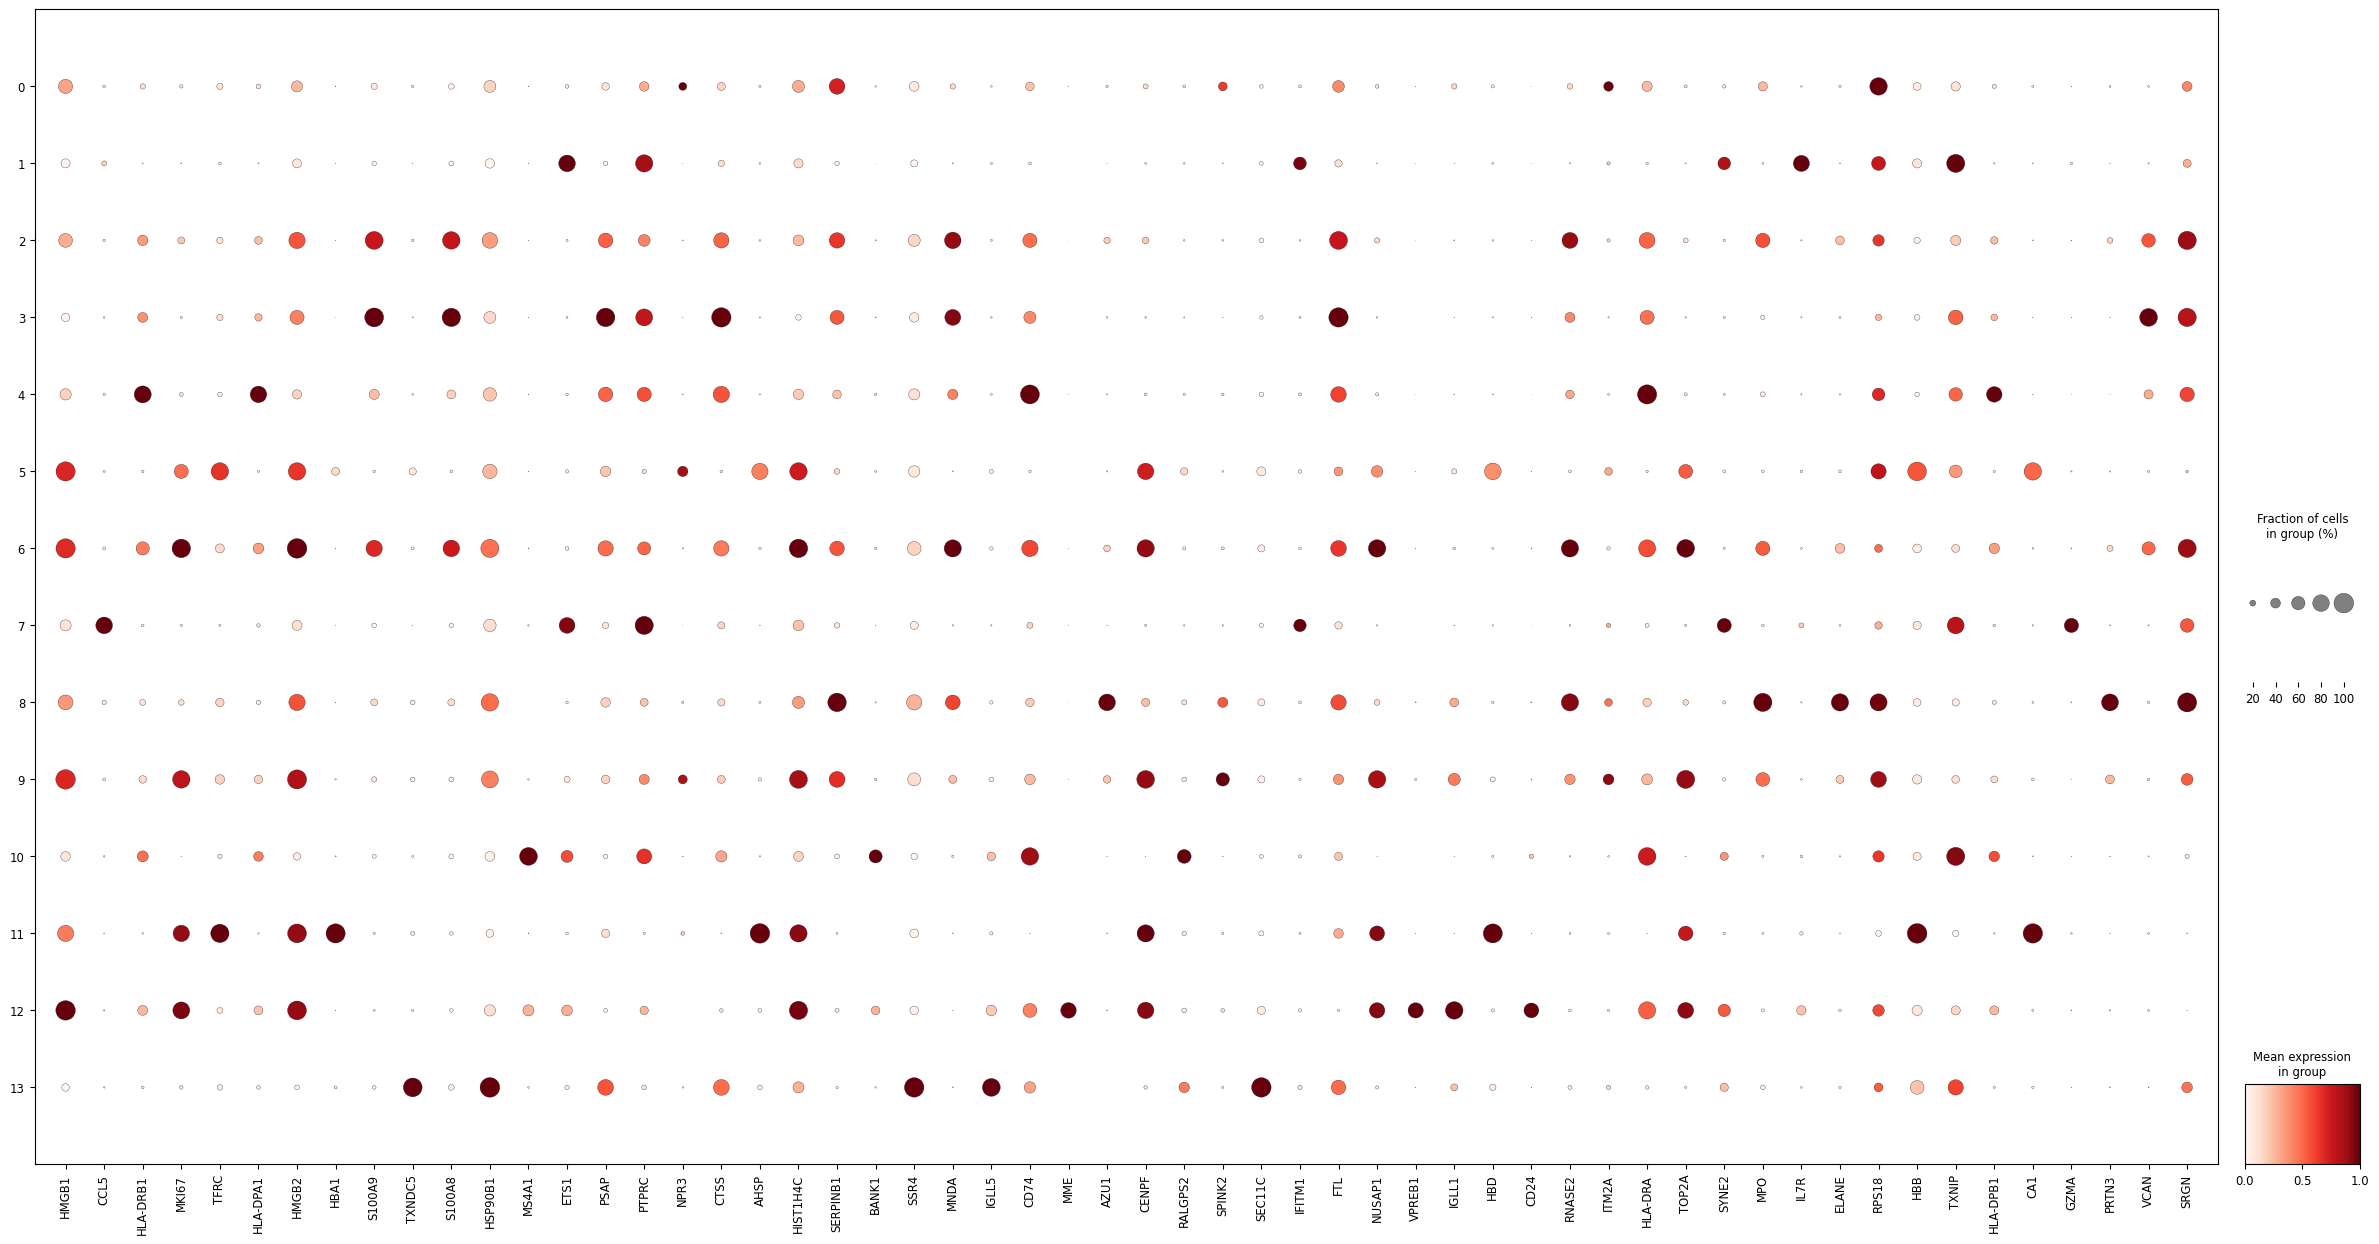

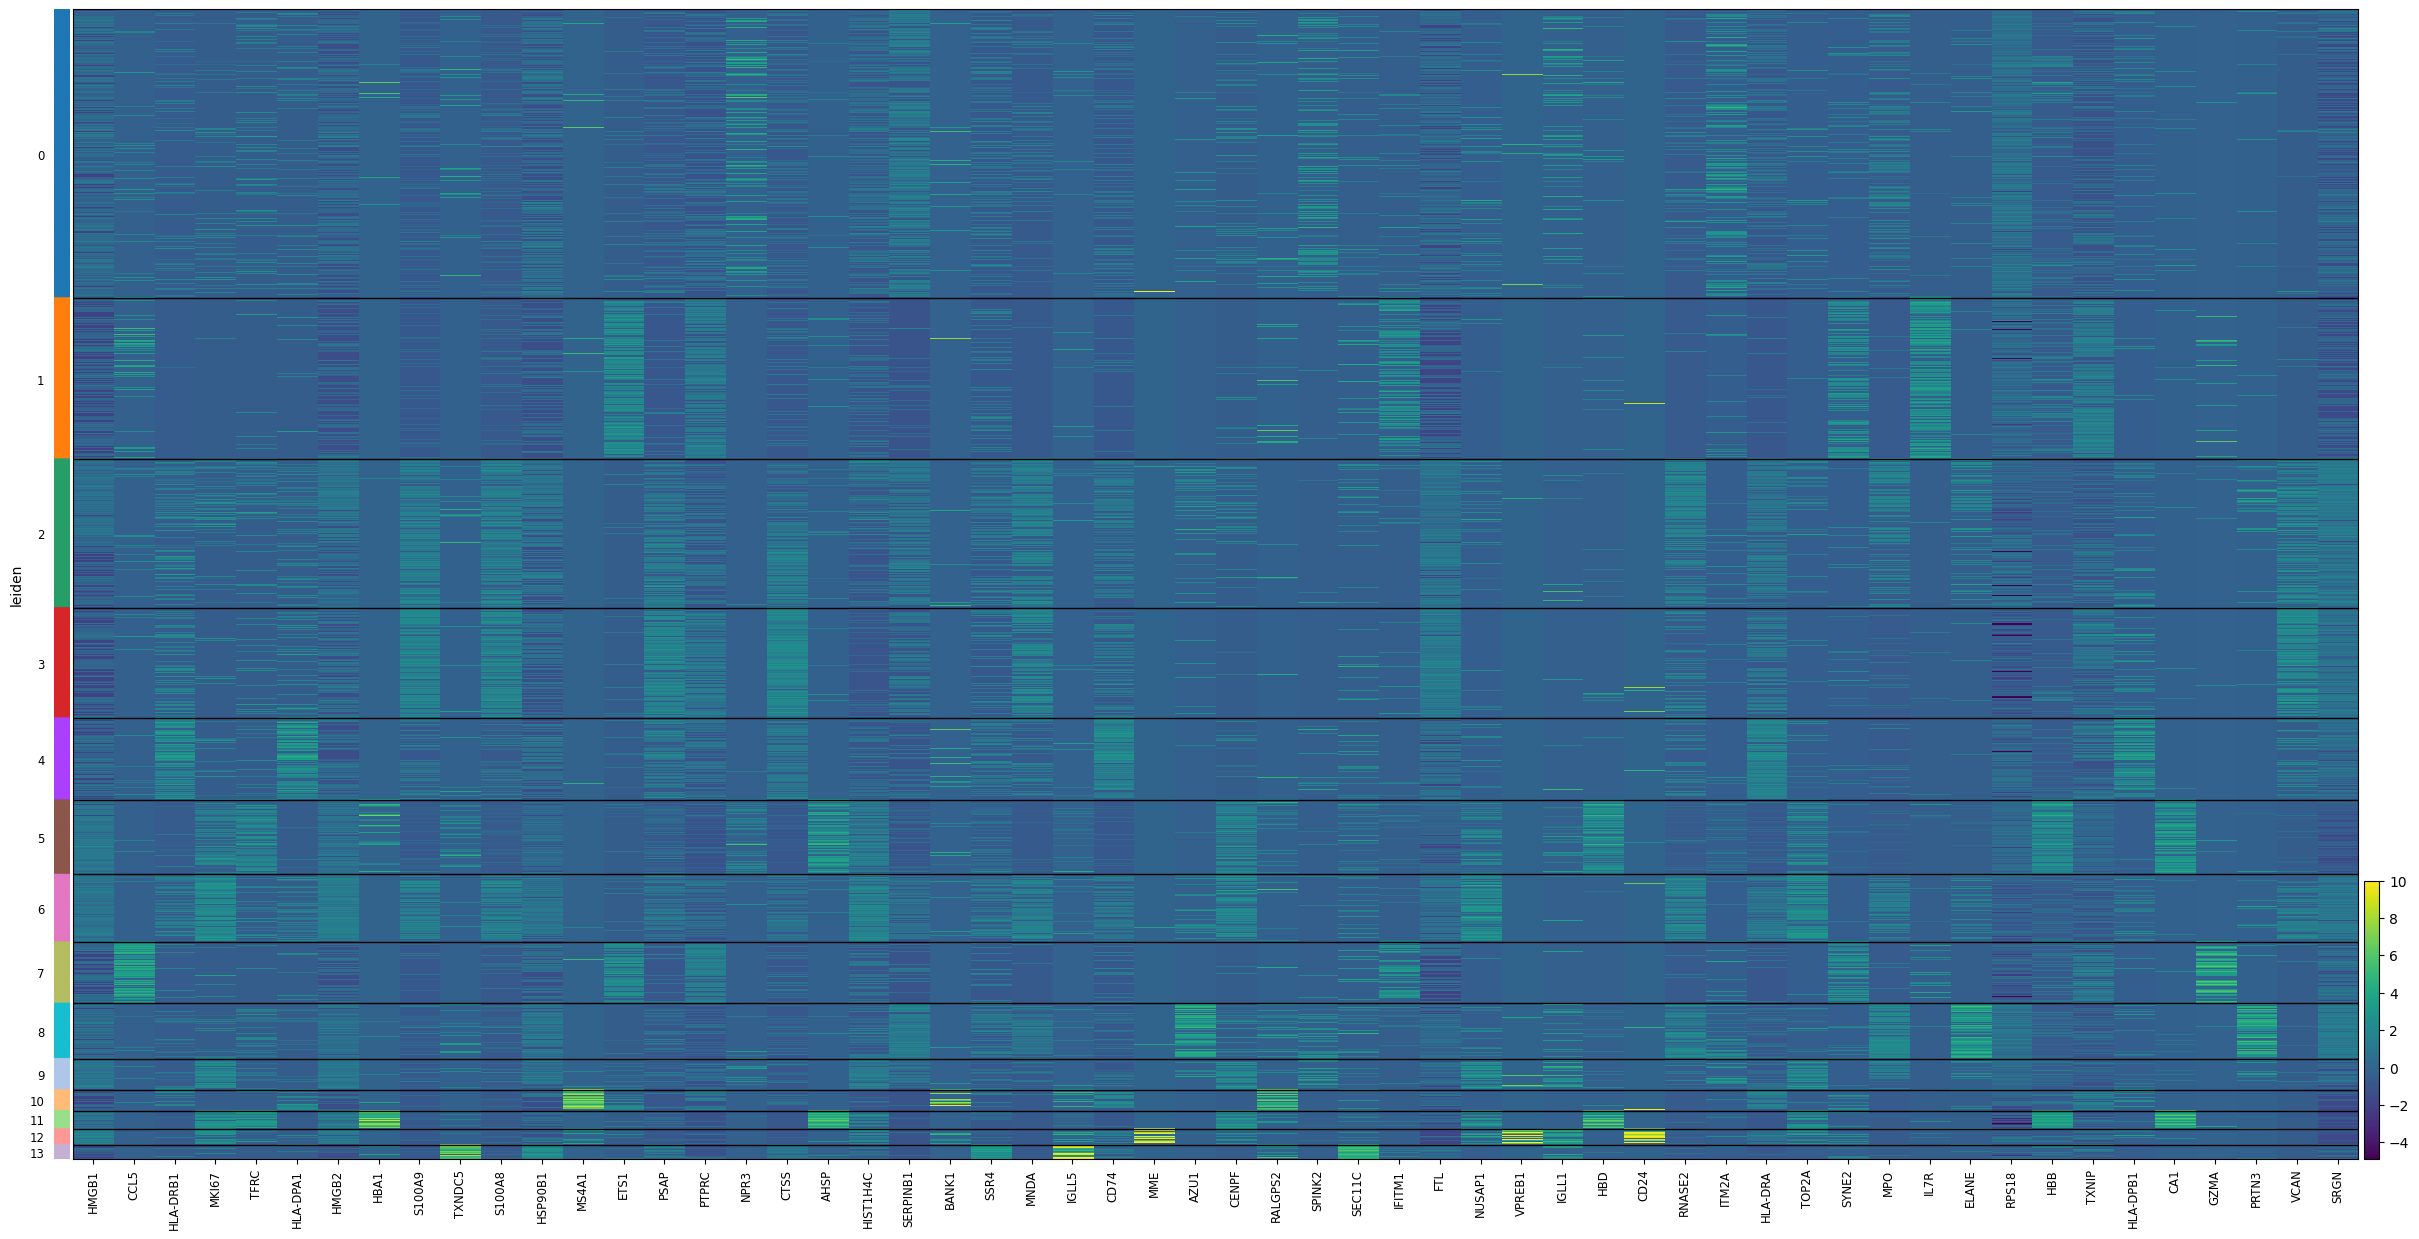

In [60]:
# Собираем список уникальных маркерных генов
marker_genes = list(top_genes_df.loc[:, "Gene_1":"Gene_5"].values.flatten())
marker_genes = list(set(marker_genes))

# Dotplot
sc.pl.dotplot(adata, marker_genes, groupby="leiden", standard_scale="var", figsize=(30, 15))

# Heatmap
sc.pl.heatmap(adata, marker_genes, groupby="leiden", show_gene_labels=True, figsize=(30, 15))

# Сохраняем таблицу топ-5 генов по каждому кластеру
top_genes_df.to_csv("top5_marker_genes_per_cluster_table.csv", index=False)

### Визуализация отдельных топ-генов

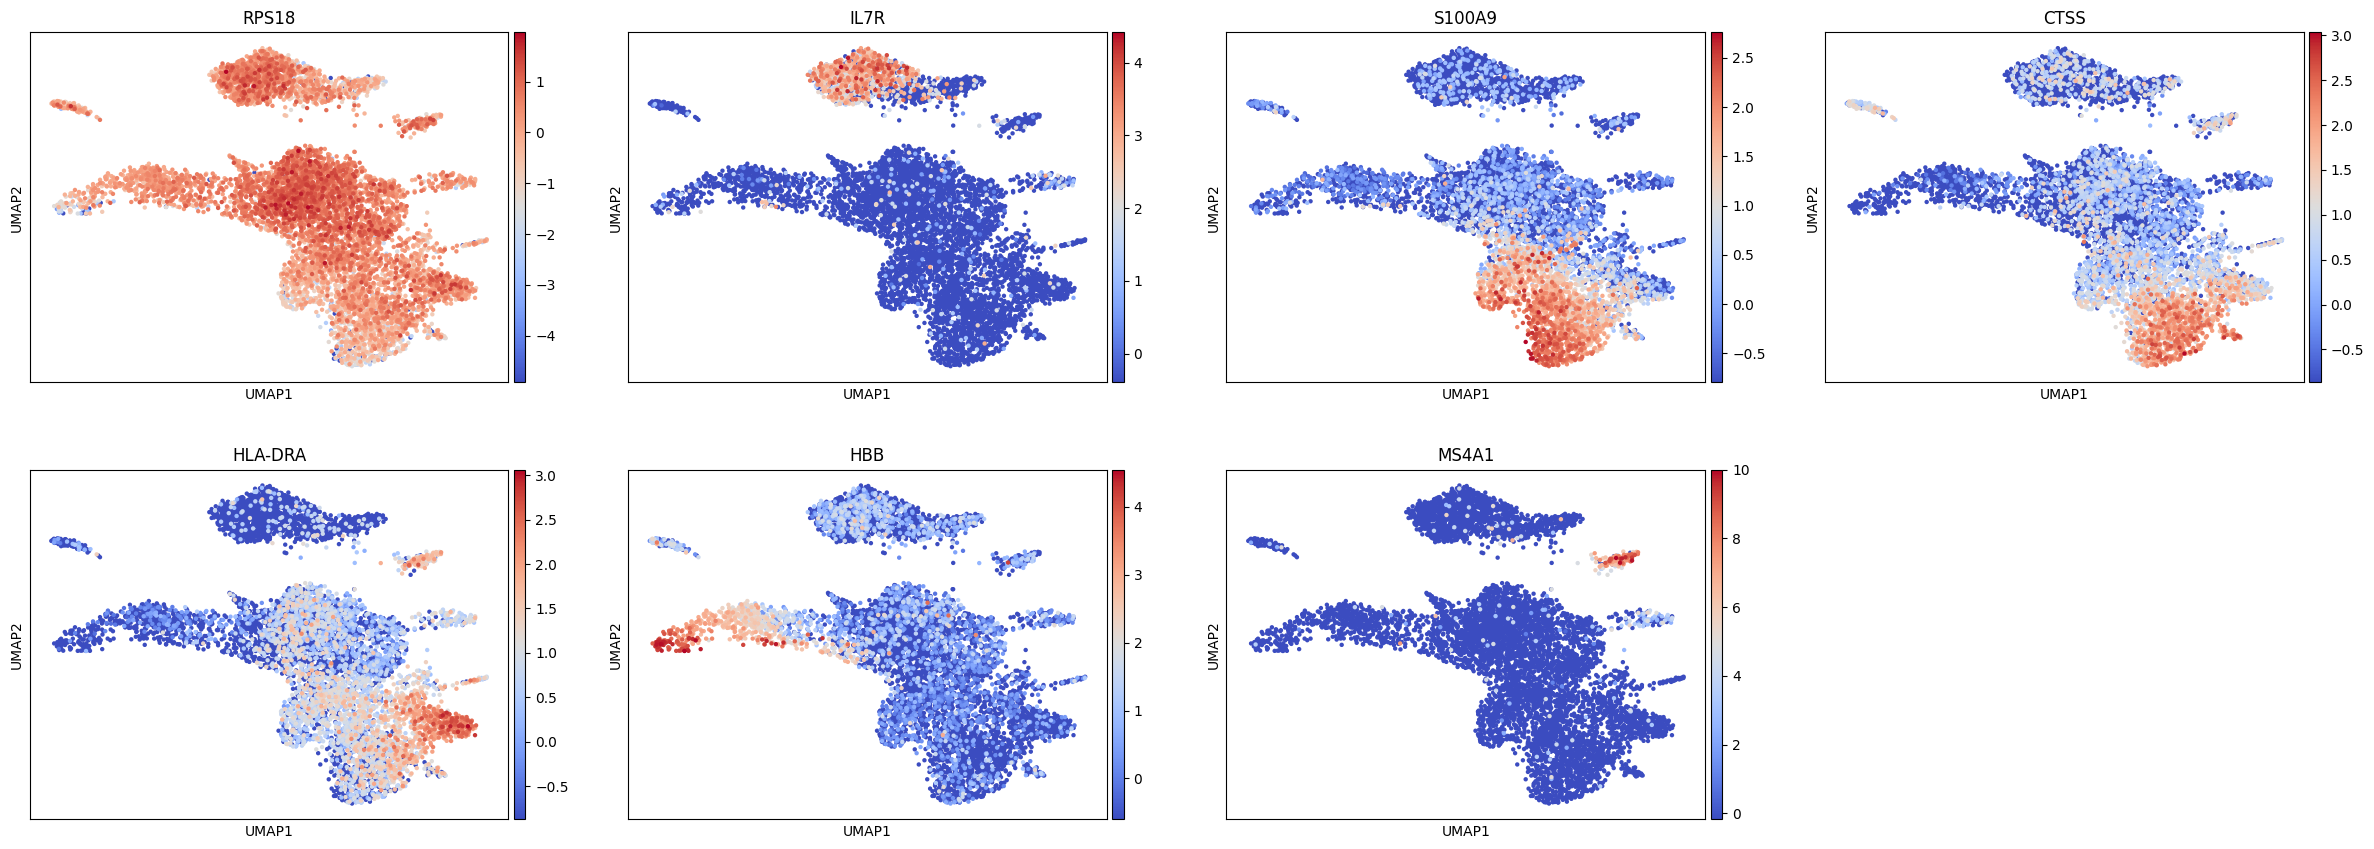

In [63]:
example_genes = [
    "RPS18",   # Cluster 0
    "IL7R",    # Cluster 1
    "S100A9",  # Cluster 2
    "CTSS",    # Cluster 3
    "HLA-DRA", # Cluster 4
    "HBB",     # Cluster 5
    "MS4A1"    # Cluster 10
]

sc.pl.umap(adata, color=example_genes, cmap="coolwarm", size=40)

## scRNA-seq (GSE116256):
Проанализированы 6 AML пациентов и 3 здоровых донора (BM).

После QC-фильтрации, нормализации и снижения размерности проведена кластеризация (Leiden) и визуализация (UMAP).

Harmony применён для коррекции возможных батч-эффектов между пациентами и контролями.

Обнаружены четкие кластеры клеток, отличающиеся по экспрессии ключевых маркерных генов (например, HBB, S100A8, CD74, MKI67 и др.).

Проведена идентификация маркерных генов для каждого кластера, а также визуализация (dotplot и heatmap).

### Ответы на вопросы:

Вопрос 1:
Если PCA для bulk RNA-seq образца показывает значительное отличие между группами образцов. Может ли оно быть вызвано батч эффектом?

Ответ:

Да, значительное отличие между группами на PCA может быть вызвано батч-эффектом — техническими различиями, связанными с подготовкой, секвенированием или обработкой образцов. Чтобы подтвердить это, нужно провести дополнительный анализ с учётом метаданных (даты, лоты, лаборатории и т.д.). В данном исследовании батч-эффект не проверялся отдельно, однако очевидная группировка реплик по времени указывает скорее на биологические различия, чем на технические артефакты.

Вопрос 2:
Зачем делают PCA перед тем как проводить tSNE или UMAP преобразование для scRNA-seq данных?

Ответ:

PCA используется как этап понижения размерности перед t-SNE или UMAP, чтобы:

убрать шум и оставить только информативные признаки;

ускорить работу t-SNE/UMAP (работают с 10–50 компонент вместо 20 000 генов);

уменьшить риски переобучения и повысить устойчивость кластеризации. Таким образом, PCA помогает более надёжно и эффективно визуализировать структуру данных в t-SNE/UMAP.

Вопрос 3:
На UMAP графике вы видите, что 1 и 3 кластер ближе к 4, чем 2. Можно ли считать, что 2 кластер содержит больше дифференциально экспрессирующихся генов по сравнению с 4, чем 1 и 3?

Ответ:

Нет, нельзя напрямую делать выводы о числе дифференциально экспрессирующихся генов на основании расстояний между кластерами на UMAP. UMAP — это нелинейное отображение, и расстояния на графике не обязательно отражают степень транскриптомных различий. Для оценки DEG между кластерами нужно использовать методы статистического анализа (например, Wilcoxon-тест, как сделано в этом проекте).